In [2]:
import pandas as pd
import numpy as np

#seaborn이나 matplotlib 사용하기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time

#sklearn 라이브러리를 사용하기
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

%matplotlib inline
import matplotlib.gridspec as GridSpec

#pywt와  scipy라이브러리 사용하기
import pywt
from scipy import fftpack
from scipy import signal
from scipy import optimize
import itertools

# 데이터 셋

예측 및 상태 관리는 다운타임 및 장애를 방지하기 위한 자산 상태 예측을 위해 업계에서 중요한 주제이다. NASA TURBOFAN 데이터 셋은 NASA의 자산 열화 모델링의 가장 대표적인 데이터 셋이다.

데이터 셋에는 터보 팬 제트 엔진의 Run-to-Fail 시뮬레이션 데이터가 포함되어 있다.

Nasa Turbofan 데이터는 작동 조건과 고장 모드에 따라서 4가지 세트로 분류되어 있다. 이 중 1첫번째 데이터 셋인 FD001 데이터 셋을 활용하여 분석에 사용할 예정이다.

데이터 세트는 서로 다른 엔진 센서의 다변량 시계열로 구성된다. 각 데이터 세트는 훈련, 테스트, RUL 세트로 나뉜다.

각 엔진은 초기 마모 및 제조 변동 정도가 서로 다른 상태에서 시작한다. 이러한 마모 및 변동은 정상으로 간주된다.(결함 상태가 아니다)

엔진은 정상적으로 작동하다 어느 시점에서 고장이 발생한다. 훈련 세트에서는 시스템 고장이 발생할 때까지 고장의 크기가 커진다. 이때 각 데이터는 센서 노이즈로 오염되어 있다.

테스트 세트에서는 시게열이 시스템 고장보다 어느 정도 먼저 종료된다. 해당 분석 목정은 테스트 세트에서 고장이 발생하기 전 남은 작동 사이클 수, 즉 엔진이 계속 작동할 마지막 사이클 이후의 작동 사이클 수를 예측하는 것이다.

RUL 데이터 셋에서는 테스트 데이터 셋에 대한 RUL 값 또한 제공한다.

데이터의 attribute은 총 26개이다. sensor 값은 21개, 기계 고유 번호, 사이클 수, optset 3개(3가지 다른 세팅 환경), RUL로 이루어져있다.

각 인스턴스는 엔진의 단일 작동 사이클 동안 포착된 데이터의 스냅샷을 나타낸다.

데이터 셋 명칭: FD001

100개의 엔진을 가지고 데이터셋을 구축했다.

# 분석 목표: RUL(잔여 수명 예측)

본 분석의 목표는 테스트 데이터 세트의 각 엔진의 잔여 수명 예측을 하는 것이다. 잔여수명은 테스트 데이터 세트의 마지막 데이터 포인트 이후 엔진에 대해 남은 비행 횟수이다.

해당 분석에는 Health Indicator(건전성 지표)를 활용하여 잔여 수명 예측을 하였다.

matlab의 유상성 모델을 적극 참조하였다.

-----------------------------------------------------------------
[Matlab exponential degradation model](https://kr.mathworks.com/help/predmaint/ug/wind-turbine-high-speed-bearing-prognosis.html)

-----------------------------------------------------------------

1. 단조 특성을 사용하여 예지 진단을 위해 특징의 이점을 수량화한다.

2. PCA를 사용하여 건전성 지표를 생성한다.

3. 잔여 수명(RUL) 추정을 위해 지수 성능 저하 모델 피팅하기

In [3]:
#데이터 셋 불러오기(train 데이터, test 데이터, rul 데이터)
def prepare_data(dir_path):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    df_train = pd.read_csv(dir_path+ 'train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv(dir_path + 'test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    y_true = pd.read_csv(dir_path + 'RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index + 1

    return df_train, df_test, y_true

In [4]:
dir_path = '/Users/jinchan/edjjincode/NiseLabProject/Data/'

In [5]:
df_train, df_test, y_true = prepare_data(dir_path)
df_train.shape, df_test.shape, y_true.shape

((20631, 27), (13096, 26), (100, 2))

In [6]:
df_train.head()

UnitNumber  Cycle  OpSet1  OpSet2  OpSet3  SensorMeasure1  SensorMeasure2  \
0           1      1 -0.0007 -0.0004   100.0          518.67          641.82   
1           1      2  0.0019 -0.0003   100.0          518.67          642.15   
2           1      3 -0.0043  0.0003   100.0          518.67          642.35   
3           1      4  0.0007  0.0000   100.0          518.67          642.35   
4           1      5 -0.0019 -0.0002   100.0          518.67          642.37   

   SensorMeasure3  SensorMeasure4  SensorMeasure5  ...  SensorMeasure13  \
0         1589.70         1400.60           14.62  ...          2388.02   
1         1591.82         1403.14           14.62  ...          2388.07   
2         1587.99         1404.20           14.62  ...          2388.03   
3         1582.79         1401.87           14.62  ...          2388.08   
4         1582.85         1406.22           14.62  ...          2388.04   

   SensorMeasure14  SensorMeasure15  SensorMeasure16  SensorMeasure17  \
0          8138.62           8.4195             0.03              392   
1          8131.49           8.4318             0.03              392   
2          8133.23           8.4178             0.03              390   
3          8133.83           8.3682             0.03              392   
4          8133.80           8.4294             0.03              393   

   SensorMeasure18  SensorMeasure19  SensorMeasure20  SensorMeasure21  RUL  
0             2388            100.0            39.06          23.4190  191  
1             2388            100.0            39.00          23.4236  190  
2             2388            100.0            38.95          23.3442  189  
3             2388            100.0            38.88          23.3739  188  
4             2388            100.0            38.90          23.4044  187  

[5 rows x 27 columns]

In [7]:
index_names = ['UnitNumber', 'Cycle']
df_train[index_names].describe()

UnitNumber         Cycle
count  20631.000000  20631.000000
mean      51.506568    108.807862
std       29.227633     68.880990
min        1.000000      1.000000
25%       26.000000     52.000000
50%       52.000000    104.000000
75%       77.000000    156.000000
max      100.000000    362.000000

In [8]:
df_train[index_names].groupby("UnitNumber").max().describe()

Cycle
count  100.000000
mean   206.310000
std     46.342749
min    128.000000
25%    177.000000
50%    199.000000
75%    229.250000
max    362.000000

In [9]:
sensor_cols = [f"SensorMeasure{i}" for i in range(1, 22)]

In [10]:
df_train[sensor_cols].describe().transpose()

count         mean           std        min        25%  \
SensorMeasure1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   
SensorMeasure2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   
SensorMeasure3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
SensorMeasure4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
SensorMeasure5   20631.0    14.620000  3.394700e-12    14.6200    14.6200   
SensorMeasure6   20631.0    21.609803  1.388985e-03    21.6000    21.6100   
SensorMeasure7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   
SensorMeasure8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500   
SensorMeasure9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000   
SensorMeasure10  20631.0     1.300000  4.660829e-13     1.3000     1.3000   
SensorMeasure11  20631.0    47.541168  2.670874e-01    46.8500    47.3500   
SensorMeasure12  20631.0   521.413470  7.375534e-01   518.6900   520.9600   
SensorMeasure13  20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400   
SensorMeasure14  20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450   
SensorMeasure15  20631.0     8.442146  3.750504e-02     8.3249     8.4149   
SensorMeasure16  20631.0     0.030000  1.556432e-14     0.0300     0.0300   
SensorMeasure17  20631.0   393.210654  1.548763e+00   388.0000   392.0000   
SensorMeasure18  20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000   
SensorMeasure19  20631.0   100.000000  0.000000e+00   100.0000   100.0000   
SensorMeasure20  20631.0    38.816271  1.807464e-01    38.1400    38.7000   
SensorMeasure21  20631.0    23.289705  1.082509e-01    22.8942    23.2218   

                       50%        75%        max  
SensorMeasure1    518.6700   518.6700   518.6700  
SensorMeasure2    642.6400   643.0000   644.5300  
SensorMeasure3   1590.1000  1594.3800  1616.9100  
SensorMeasure4   1408.0400  1414.5550  1441.4900  
SensorMeasure5     14.6200    14.6200    14.6200  
SensorMeasure6     21.6100    21.6100    21.6100  
SensorMeasure7    553.4400   554.0100   556.0600  
SensorMeasure8   2388.0900  2388.1400  2388.5600  
SensorMeasure9   9060.6600  9069.4200  9244.5900  
SensorMeasure10     1.3000     1.3000     1.3000  
SensorMeasure11    47.5100    47.7000    48.5300  
SensorMeasure12   521.4800   521.9500   523.3800  
SensorMeasure13  2388.0900  2388.1400  2388.5600  
SensorMeasure14  8140.5400  8148.3100  8293.7200  
SensorMeasure15     8.4389     8.4656     8.5848  
SensorMeasure16     0.0300     0.0300     0.0300  
SensorMeasure17   393.0000   394.0000   400.0000  
SensorMeasure18  2388.0000  2388.0000  2388.0000  
SensorMeasure19   100.0000   100.0000   100.0000  
SensorMeasure20    38.8300    38.9500    39.4300  
SensorMeasure21    23.2979    23.3668    23.6184

In [11]:
sc = MinMaxScaler(feature_range=(0,1))
df_train[sensor_cols] = sc.fit_transform(df_train[sensor_cols])
df_test[sensor_cols] = sc.transform(df_test[sensor_cols])

/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isi

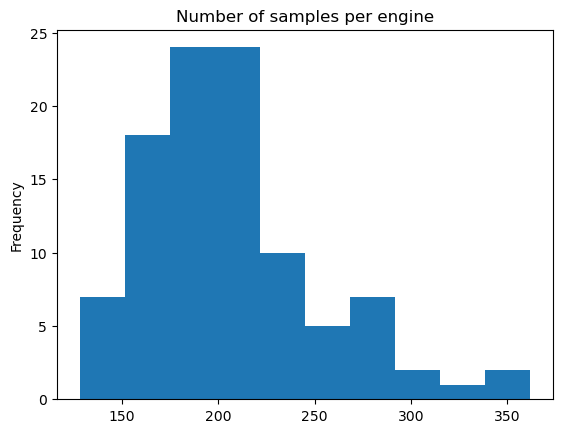

In [12]:
df_train.groupby("UnitNumber").size().plot(kind="hist")
plt.title("Number of samples per engine")
plt.show()

In [13]:
df_sensors = df_train[sensor_cols]

In [14]:
window = 5

In [15]:
df_train_mean = df_train.groupby('UnitNumber')[sensor_cols].rolling(window = window).mean()
df_train_mean = df_train_mean.reset_index()
df_train_mean.dropna(inplace = True)
df_train_mean.drop(['level_1'], axis = 1, inplace = True)
df_train_mean.head()

UnitNumber  SensorMeasure1  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
4           1             0.0        0.300602        0.348594        0.353747   
5           1             0.0        0.317470        0.325790        0.346219   
6           1             0.0        0.337349        0.327970        0.328089   
7           1             0.0        0.350000        0.306039        0.317184   
8           1             0.0        0.336145        0.341748        0.293315   

   SensorMeasure5  SensorMeasure6  SensorMeasure7  SensorMeasure8  \
4             0.0             1.0        0.694686        0.257576   
5             0.0             1.0        0.704670        0.245455   
6             0.0             1.0        0.723671        0.239394   
7             0.0             1.0        0.710467        0.215152   
8             0.0             1.0        0.685990        0.196970   

   SensorMeasure9  ...  SensorMeasure12  SensorMeasure13  SensorMeasure14  \
4        0.124904  ...         0.765885         0.247059         0.176767   
5        0.128036  ...         0.766738         0.250000         0.170812   
6        0.141551  ...         0.768443         0.238235         0.171669   
7        0.130656  ...         0.770576         0.238235         0.169440   
8        0.127946  ...         0.724947         0.229412         0.161038   

   SensorMeasure15  SensorMeasure16  SensorMeasure17  SensorMeasure18  \
4         0.340285              0.0         0.316667              0.0   
5         0.333590              0.0         0.300000              0.0   
6         0.307118              0.0         0.300000              0.0   
7         0.299269              0.0         0.316667              0.0   
8         0.302809              0.0         0.316667              0.0   

   SensorMeasure19  SensorMeasure20  SensorMeasure21  
4              0.0         0.634109         0.688788  
5              0.0         0.621705         0.674399  
6              0.0         0.637209         0.661640  
7              0.0         0.640310         0.652361  
8              0.0         0.666667         0.661392  

[5 rows x 22 columns]

In [16]:
df_train_mean.shape

(20231, 22)

In [17]:
df_lag = df_train_mean.groupby('UnitNumber').diff(1)
df_lag['UnitNumber'] = df_train_mean['UnitNumber']
df_lag.dropna(inplace = True)
df_lag = df_lag.reset_index(drop = True)
df_lag.head()

SensorMeasure1  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0             0.0        0.016867       -0.022804       -0.007529   
1             0.0        0.019880        0.002180       -0.018130   
2             0.0        0.012651       -0.021932       -0.010905   
3             0.0       -0.013855        0.035710       -0.023869   
4             0.0       -0.039759        0.036582       -0.019446   

   SensorMeasure5  SensorMeasure6  SensorMeasure7  SensorMeasure8  \
0             0.0             0.0        0.009984       -0.012121   
1             0.0             0.0        0.019002       -0.006061   
2             0.0             0.0       -0.013205       -0.024242   
3             0.0             0.0       -0.024477       -0.018182   
4             0.0             0.0       -0.013205       -0.003030   

   SensorMeasure9  SensorMeasure10  ...  SensorMeasure13  SensorMeasure14  \
0        0.003132              0.0  ...         0.002941        -0.005955   
1        0.013515              0.0  ...        -0.011765         0.000857   
2       -0.010895              0.0  ...         0.000000        -0.002229   
3       -0.002710              0.0  ...        -0.008824        -0.008401   
4       -0.003096              0.0  ...         0.005882        -0.004562   

   SensorMeasure15  SensorMeasure16  SensorMeasure17  SensorMeasure18  \
0        -0.006695              0.0        -0.016667              0.0   
1        -0.026472              0.0         0.000000              0.0   
2        -0.007849              0.0         0.016667              0.0   
3         0.003540              0.0         0.000000              0.0   
4        -0.000616              0.0         0.000000              0.0   

   SensorMeasure19  SensorMeasure20  SensorMeasure21  UnitNumber  
0              0.0        -0.012403        -0.014388           1  
1              0.0         0.015504        -0.012759           1  
2              0.0         0.003101        -0.009279           1  
3              0.0         0.026357         0.009031           1  
4              0.0         0.007752         0.017951           1  

[5 rows x 22 columns]

## 특징 중요도 순위 지정

단조 특성을 사용하여 예지 진단을 위해 특징의 이점을 수량화 한다.

## 단조 특성:

단조 특성은 어떤 변수나 특성이 다른 변수나 특성과의 관계가 항상 증가하거나 감소하는 경향을 가지는 것을 의미한다. 즉, 변수 X가 증가할 때 변수 Y도 증가하거나 감소하는 관계를 말한다.

단조 특성을 활용한 feature selection:

잔여 수명 예측 모델을 개발할 때, 단조 특성을 가지는 특성(feature)를 주로 선택한다.

단조 특성을 활용하여 feature selection을 하면 모델이 더 정확하고 해석 가능한 예측을 할 수 있다.

In [18]:
def monotonicity(data):

    num_pos = data[data > 0].shape[0]
    num_neg = data[data < 0].shape[0]
    tot_n = data.shape[0] - 1

    mon_val = np.abs(num_pos - num_neg)/tot_n
    return mon_val

In [33]:
mon = []
for col in sensor_cols:
    mon_val = []
    for unit in df_lag.UnitNumber.unique():
        mon_val.append(monotonicity(df_lag.loc[df_lag.UnitNumber == unit, col]))
    mon.append({'feature': col, 'monotonicity_val': np.mean(mon_val)})
mon_df = pd.DataFrame(mon)

In [34]:
mon_df = mon_df.sort_values(by = 'monotonicity_val', ascending = False)
mon_df.head()

feature  monotonicity_val
13  SensorMeasure14          0.157243
8    SensorMeasure9          0.147807
10  SensorMeasure11          0.116696
11  SensorMeasure12          0.105777
3    SensorMeasure4          0.092576

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='monotonicity_val', ylabel='feature'>

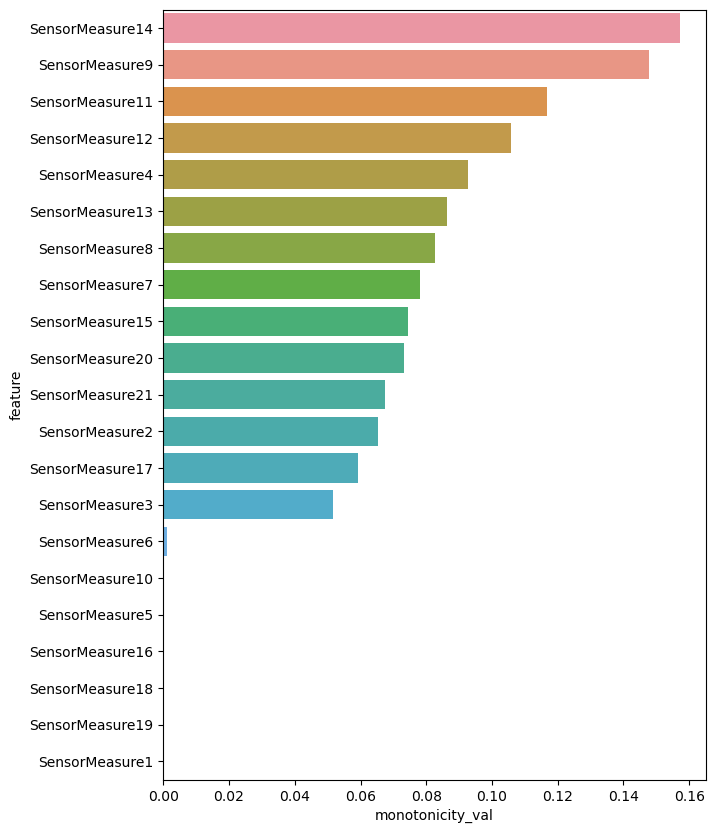

In [35]:
fig, ax = plt.subplots(figsize = (7,10))

sns.barplot(y = mon_df.feature, x = mon_df.monotonicity_val)

In [36]:
feats = mon_df.feature[mon_df.monotonicity_val > 0.08]
feats

13    SensorMeasure14
8      SensorMeasure9
10    SensorMeasure11
11    SensorMeasure12
3      SensorMeasure4
12    SensorMeasure13
7      SensorMeasure8
Name: feature, dtype: object

In [37]:
len(feats)

7

차원 축소 및 특징 융합을 위해 주성분 분석(PCA)을 사용한다. PCA를 할 때는 정규화를 진행해야 한다.

첫번째 주성분을 건정성 지표로 설정할 수 있다.

In [38]:
from sklearn.decomposition import PCA

In [39]:

pca = PCA(n_components=3)

pca_data = pca.fit_transform(df_train_mean[feats])

pca_df = pd.DataFrame(pca_data, columns = ['pc1', 'pc2', 'pc3'])
pca_df['UnitNumber'] = df_train_mean.UnitNumber.values
pca_df['cycle'] = pca_df.groupby('UnitNumber').cumcount()+1
pca_df['RUL'] = pca_df.groupby('UnitNumber').cycle.transform('max') - pca_df.cycle
pca_df.head()

/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


pc1       pc2       pc3  UnitNumber  cycle  RUL
0 -0.248184 -0.066312 -0.061014           1      1  187
1 -0.274713 -0.068857 -0.059151           1      2  186
2 -0.297202 -0.057867 -0.046933           1      3  185
3 -0.314470 -0.062486 -0.039751           1      4  184
4 -0.301991 -0.066299  0.010332           1      5  183

In [40]:
pcs = ['pc1', 'pc2', 'pc3']

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

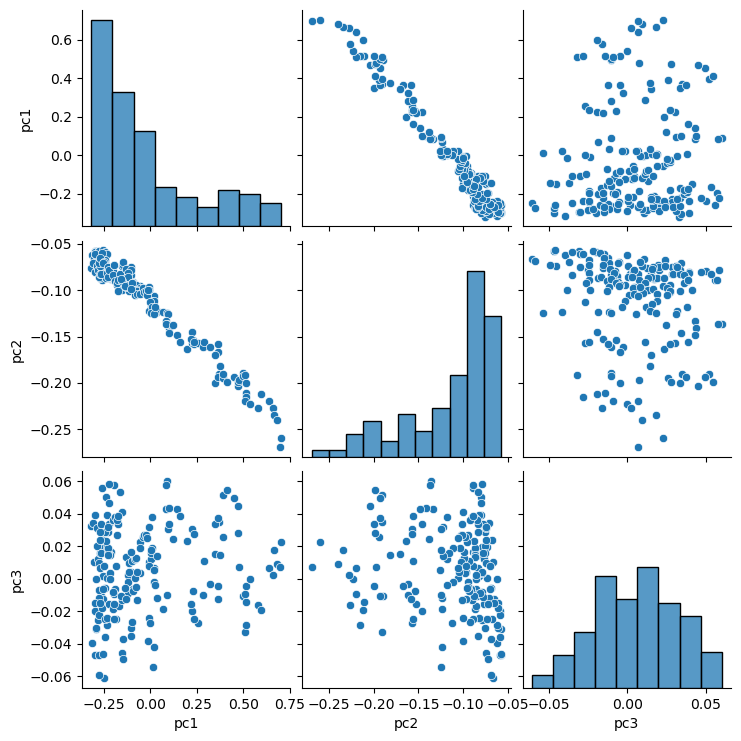

In [41]:
sns.pairplot(data = pca_df[pca_df.UnitNumber == 1], x_vars= pcs, y_vars = pcs)

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='pc1', ylabel='pc2'>

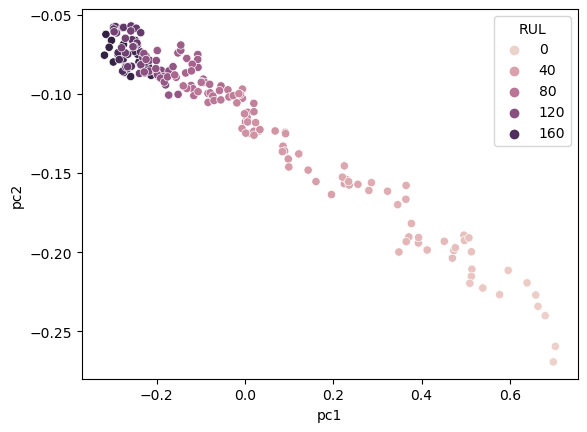

In [42]:
sns.scatterplot(data = pca_df[pca_df.UnitNumber == 1], x = "pc1", y = "pc2", hue = "RUL")

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

Text(0, 0.5, 'Health Indicator')

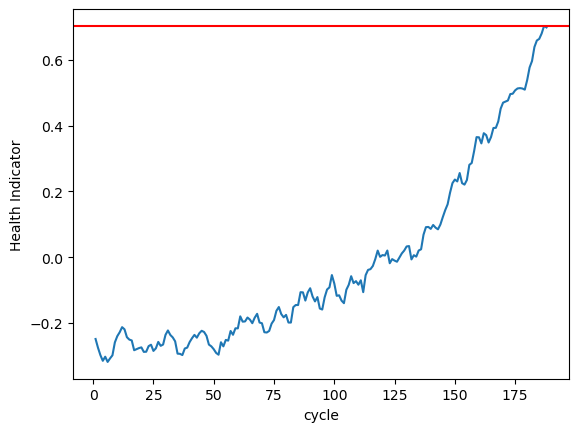

In [43]:
fig, ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.UnitNumber == 1], x = "cycle", y = "pc1", ax = ax)
plt.axhline(pca_df[pca_df.UnitNumber == 1].pc1.max(), color = 'r')
ax.set_ylabel("Health Indicator")

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

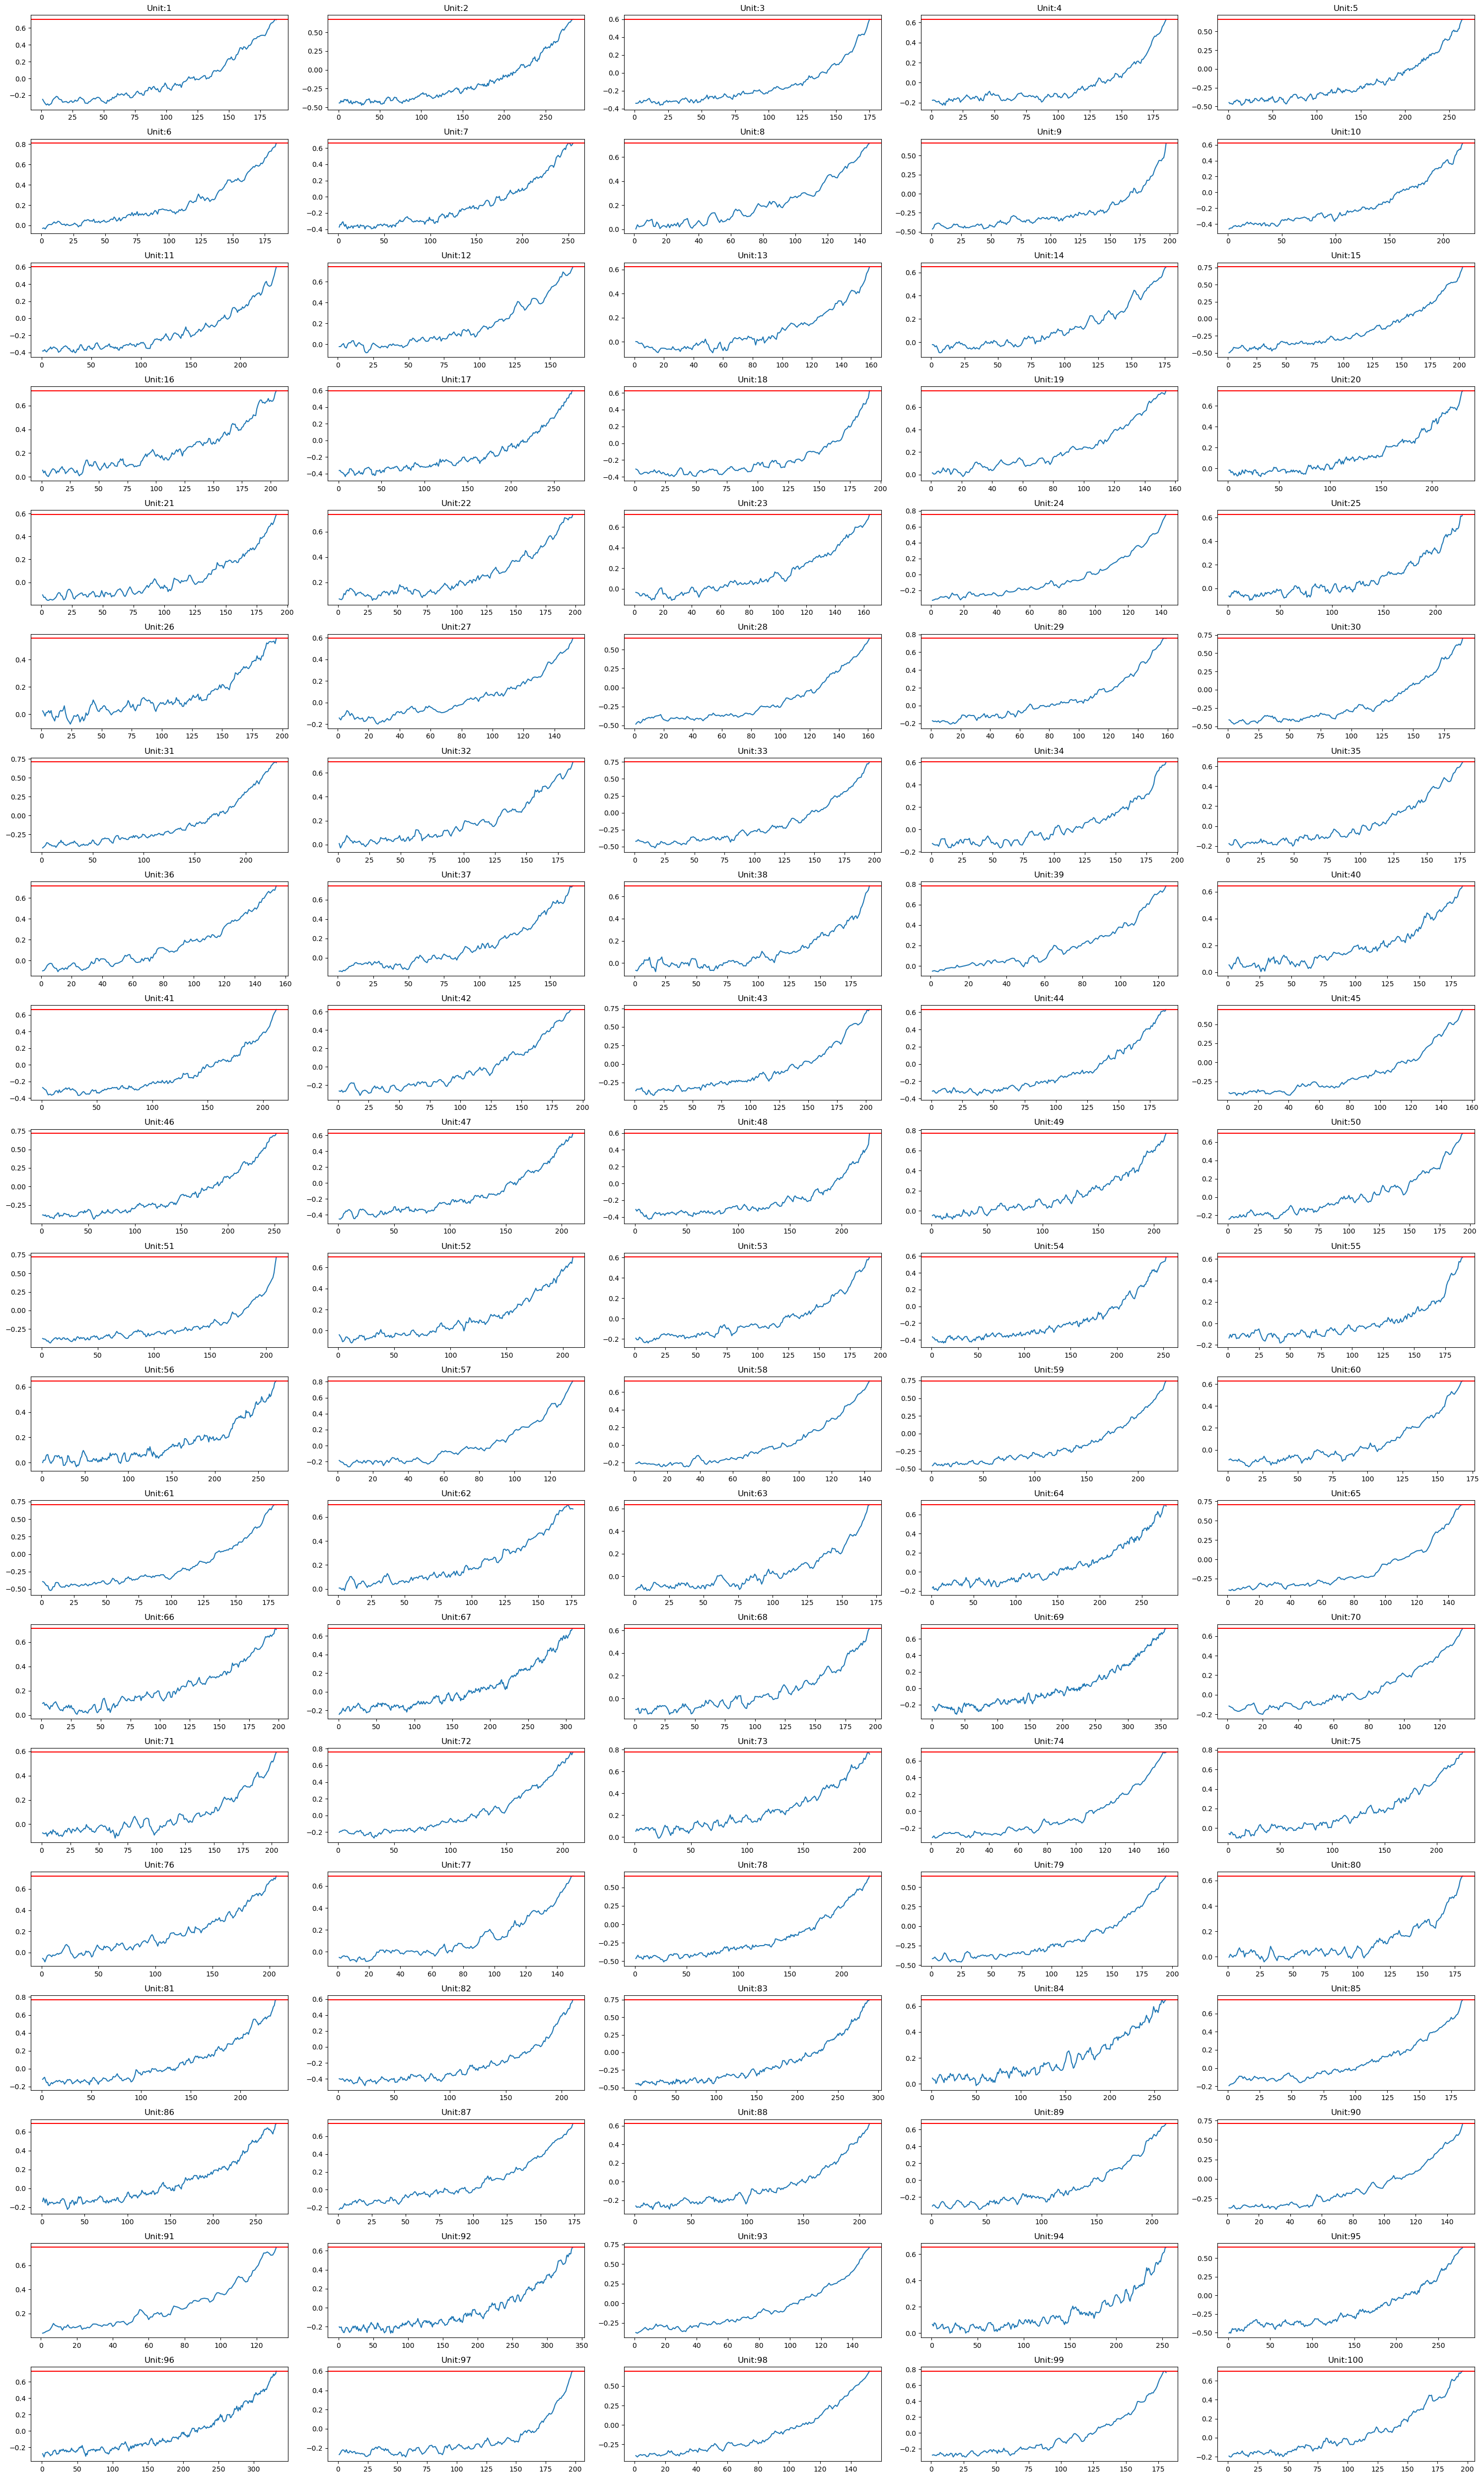

In [44]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    sns.lineplot(data = pca_df[pca_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    ax[i].axhline(pca_df[pca_df.UnitNumber == i+1].pc1.max(), color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

RUL 값 들에 따라 그래프 분포를 시각화 하였다.

/var/folders/87/g853z5ls20d2k235h1ck1zmr0000gn/T/ipykernel_94661/2158933395.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pca_df.pc1[pca_df.RUL == 0], label= "RUL: 0")
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before ope

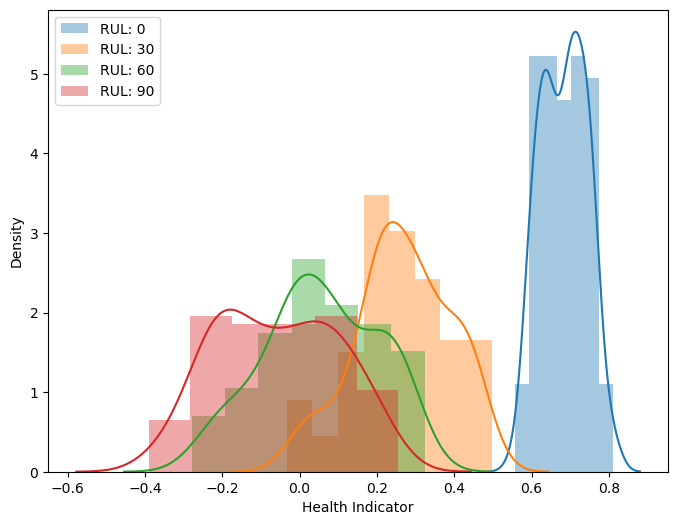

In [45]:
fig, ax = plt.subplots(figsize = (8,6))
sns.distplot(pca_df.pc1[pca_df.RUL == 0], label= "RUL: 0")
sns.distplot(pca_df.pc1[pca_df.RUL == 30], label= "RUL: 30")
sns.distplot(pca_df.pc1[pca_df.RUL == 60], label= "RUL: 60")
sns.distplot(pca_df.pc1[pca_df.RUL == 90], label= "RUL: 90")
plt.xlabel("Health Indicator")
plt.legend()
plt.show()

RUL 값이 0인 것을 threshold로 놓는다. 위 그림에서 확인할 수 있듯이 RUL 값이 0인 값을 thresholod로 했을 때 확실하게 데이터를 분류할 수 있다는 것을 알 수 있다.

따라서 RUL 값이 0인 값을 threshold로 설정하였다.

In [46]:
threshold = pca_df.pc1[pca_df.RUL == 0].mean()
threshold

0.6831239626562418

In [47]:
threshold_std = pca_df.pc1[pca_df.RUL == 0].std()
threshold_std

0.0582685478082963

/var/folders/87/g853z5ls20d2k235h1ck1zmr0000gn/T/ipykernel_94661/2576772575.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pca_df.pc1[pca_df.RUL == 0])
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
 

<Axes: xlabel='pc1', ylabel='Density'>

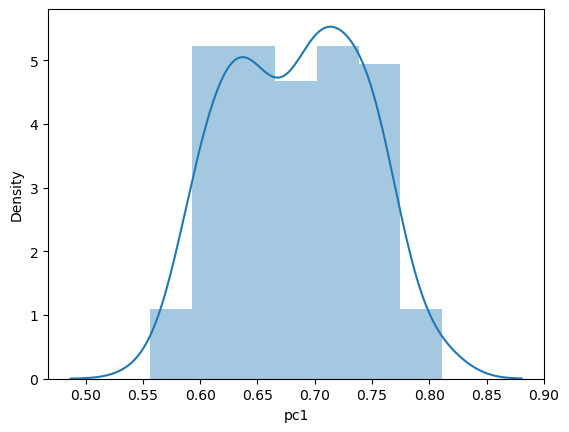

In [48]:
sns.distplot(pca_df.pc1[pca_df.RUL == 0])

지수 성능 저하 모델 수식을 세우고 건전성 지표를 생성한다.

ht = phi + theta * np.exp(beta * cycle) 수식을 세운다.

In [49]:
def exp_degradation(parameters, cycle):
    '''
    Calculate an exponetial degradation of the form:
    ht = phi + theta * exp(beta * cycle)
    '''
    phi = parameters[0]
    theta = parameters[1]
    beta = parameters[2]

    ht = phi + theta * np.exp(beta * cycle)
    return ht

In [50]:
def residuals(parameters, data, y_observed, func):
    '''
    Compute residuals of y_predicted - y_observed
    where:
    y_predicted = func(parameters,x_data)
    '''
    return func(parameters, data) - y_observed

In [51]:
param_0 = [-1, 0.01, 0.01]

In [52]:
exp_params_df = pd.DataFrame(columns = ['UnitNumber', 'phi', 'theta', 'beta'])

for i in range(1,101):

    ht = pca_df.pc1[pca_df.UnitNumber == i]
    cycle = pca_df.cycle[pca_df.UnitNumber == i]

    OptimizeResult = optimize.least_squares(residuals, param_0, args = (cycle, ht, exp_degradation))
    phi, theta, beta = OptimizeResult.x

    exp_params_df = exp_params_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta}, ignore_index = True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
exp_params_df.head()

UnitNumber       phi     theta      beta
0         1.0 -0.317813  0.032857  0.018378
1         2.0 -0.458656  0.023286  0.013751
2         3.0 -0.322023  0.007069  0.027443
3         4.0 -0.168147  0.002137  0.031951
4         5.0 -0.457298  0.023174  0.014524

Exponential Degradation 모델을 만들었다.

Text(0, 0.5, 'Health Indicator')

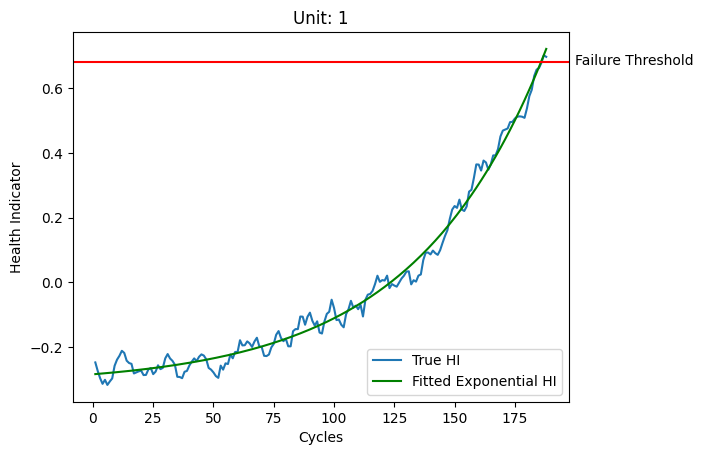

In [ ]:
phi = exp_params_df.phi[exp_params_df.UnitNumber == 1].values
theta = exp_params_df.theta[exp_params_df.UnitNumber == 1].values
beta = exp_params_df.beta[exp_params_df.UnitNumber == 1].values

cycles = pca_df.cycle[pca_df.UnitNumber == 1]
pred_ht = exp_degradation([phi, theta, beta], cycles)

fig, ax = plt.subplots()
sns.lineplot(data = pca_df[pca_df.UnitNumber == 1], x = "cycle", y = "pc1", ax = ax, label = "True HI")
sns.lineplot(y = pred_ht, x = cycles, ax = ax, color = "green", label = "Fitted Exponential HI")
ax.axhline(threshold, color = 'r')
ax.text(200,threshold - 0.01,'Failure Threshold',rotation=0)
ax.set_title("Unit: 1")
ax.set_xlabel("Cycles")
ax.set_ylabel("Health Indicator")

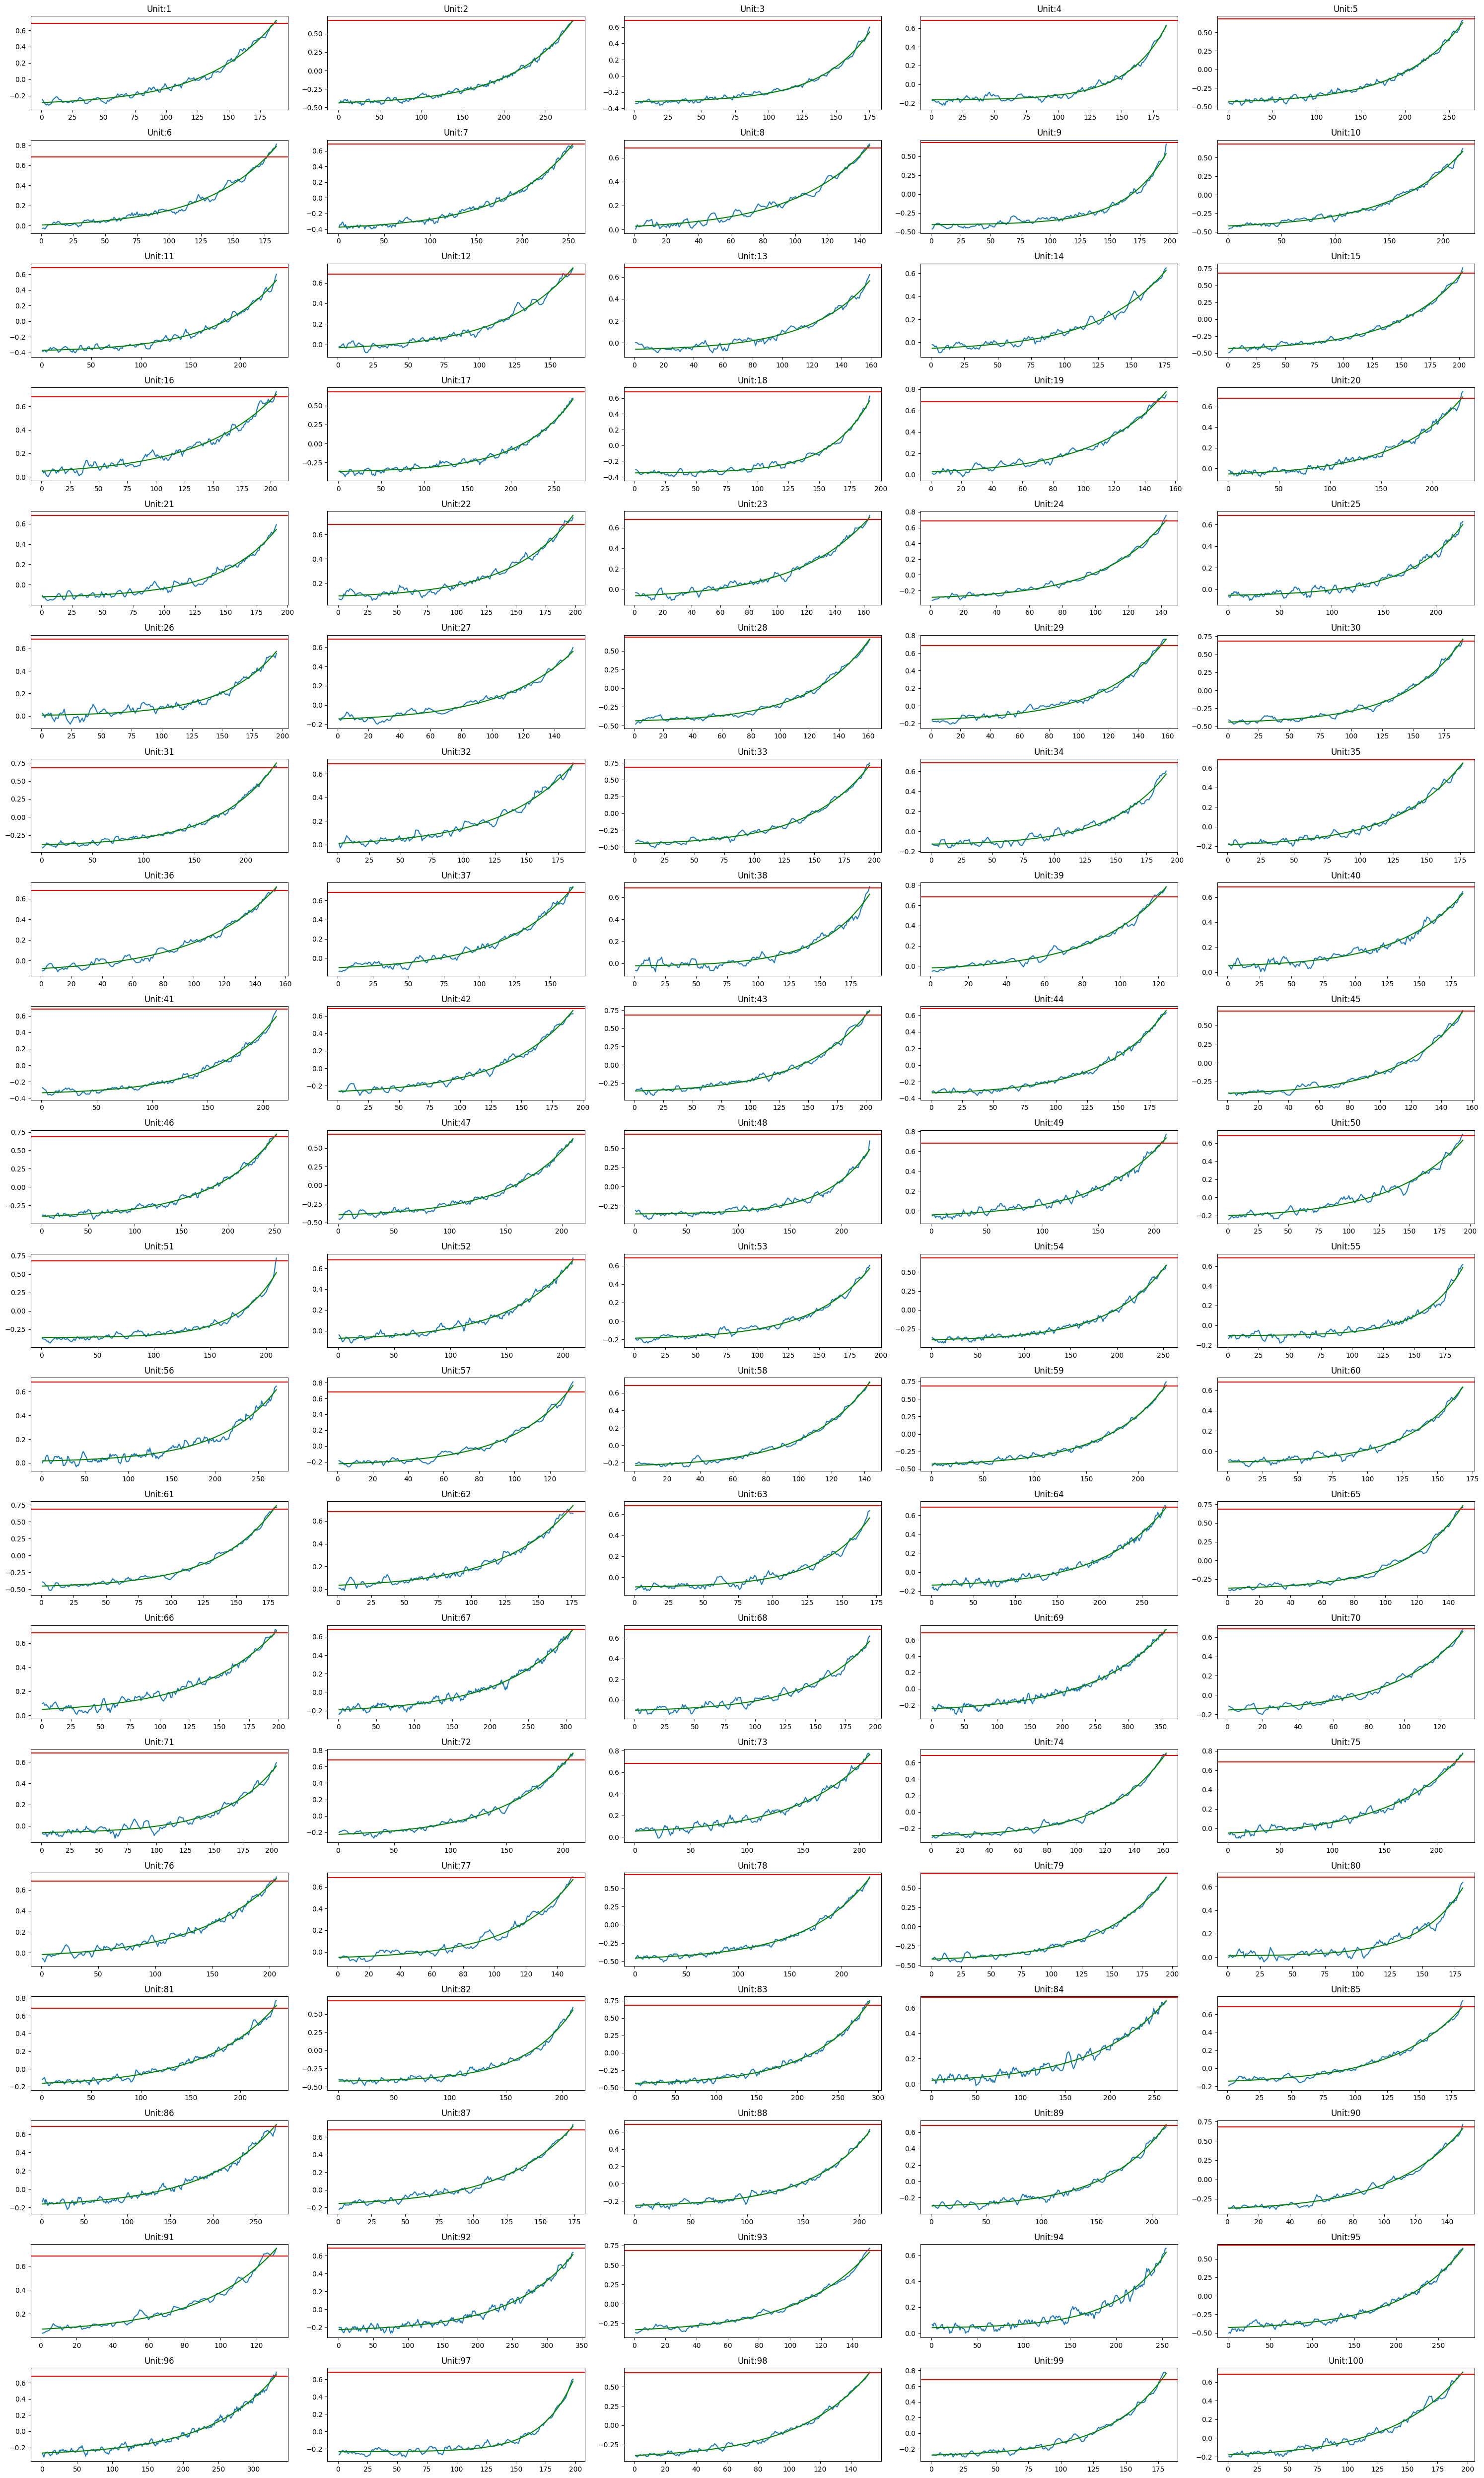

In [ ]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):

    phi = exp_params_df.phi[exp_params_df.UnitNumber == i+1].values
    theta = exp_params_df.theta[exp_params_df.UnitNumber == i+1].values
    beta = exp_params_df.beta[exp_params_df.UnitNumber == i+1].values

    cycles = pca_df.cycle[pca_df.UnitNumber == i+1]
    pred_ht = exp_degradation([phi, theta, beta], cycles)

    sns.lineplot(data = pca_df[pca_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    sns.lineplot(y = pred_ht, x = cycles, ax = ax[i], color = "green")
    ax[i].axhline(threshold, color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

/var/folders/87/g853z5ls20d2k235h1ck1zmr0000gn/T/ipykernel_94661/3696628322.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(exp_params_df.phi, ax = ax[0])
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/distributions.py:2479: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/jinchan/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jinchan/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), 

<Axes: xlabel='beta'>

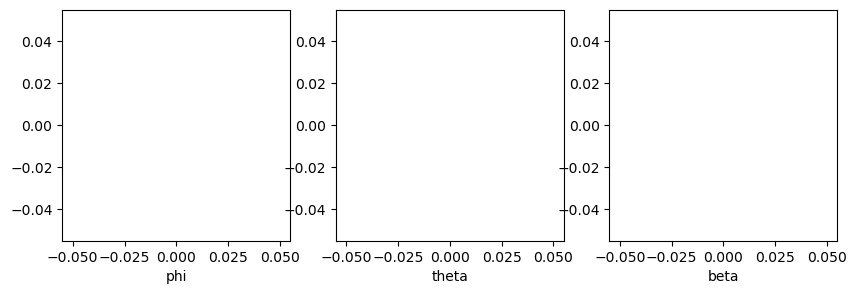

In [53]:
fig, ax = plt.subplots(figsize = (10,3), nrows = 1, ncols = 3)
sns.distplot(exp_params_df.phi, ax = ax[0])
sns.distplot(exp_params_df.theta, ax = ax[1], color = "red")
sns.distplot(exp_params_df.beta, ax = ax[2], color = "green")

In [54]:
window = 5

df_test_mean = df_test.groupby('UnitNumber')[feats].rolling(window = window).mean()
df_test_mean = df_test_mean.reset_index()
df_test_mean.dropna(inplace = True)
df_test_mean.drop(['level_1'], axis = 1, inplace = True)
df_test_mean.head()

UnitNumber  SensorMeasure14  SensorMeasure9  SensorMeasure11  \
4           1         0.163082        0.128098         0.302381   
5           1         0.165053        0.128807         0.309524   
6           1         0.160254        0.126088         0.286905   
7           1         0.155950        0.122409         0.252381   
8           1         0.157240        0.125334         0.263095   

   SensorMeasure12  SensorMeasure4  SensorMeasure13  SensorMeasure8  
4         0.679318        0.310804         0.235294        0.193939  
5         0.687846        0.300405         0.250000        0.181818  
6         0.681450        0.332208         0.250000        0.193939  
7         0.686567        0.330689         0.258824        0.193939  
8         0.714286        0.350473         0.258824        0.203030

값들을 신호처리 하기 위해 이동 평균을 사용한다.

테스트 데이터에 대해서도 PCA를 진행하고 PC1에 해당하는 값을 파라미터로 설정한다.

In [55]:
pca_test_data = pca.transform(df_test_mean[feats])

pca_test_df = pd.DataFrame(pca_test_data, columns = ['pc1', 'pc2', 'pc3'])
pca_test_df['UnitNumber'] = df_test_mean.UnitNumber.values
pca_test_df['cycle'] = pca_test_df.groupby('UnitNumber').cumcount()+1
pca_test_df.head()

/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


pc1       pc2       pc3  UnitNumber  cycle
0 -0.240220 -0.062051  0.032301           1      1
1 -0.244997 -0.061102  0.035695           1      2
2 -0.234567 -0.067320  0.012704           1      3
3 -0.253703 -0.076366  0.006504           1      4
4 -0.249429 -0.072607 -0.025517           1      5

/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jinchan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

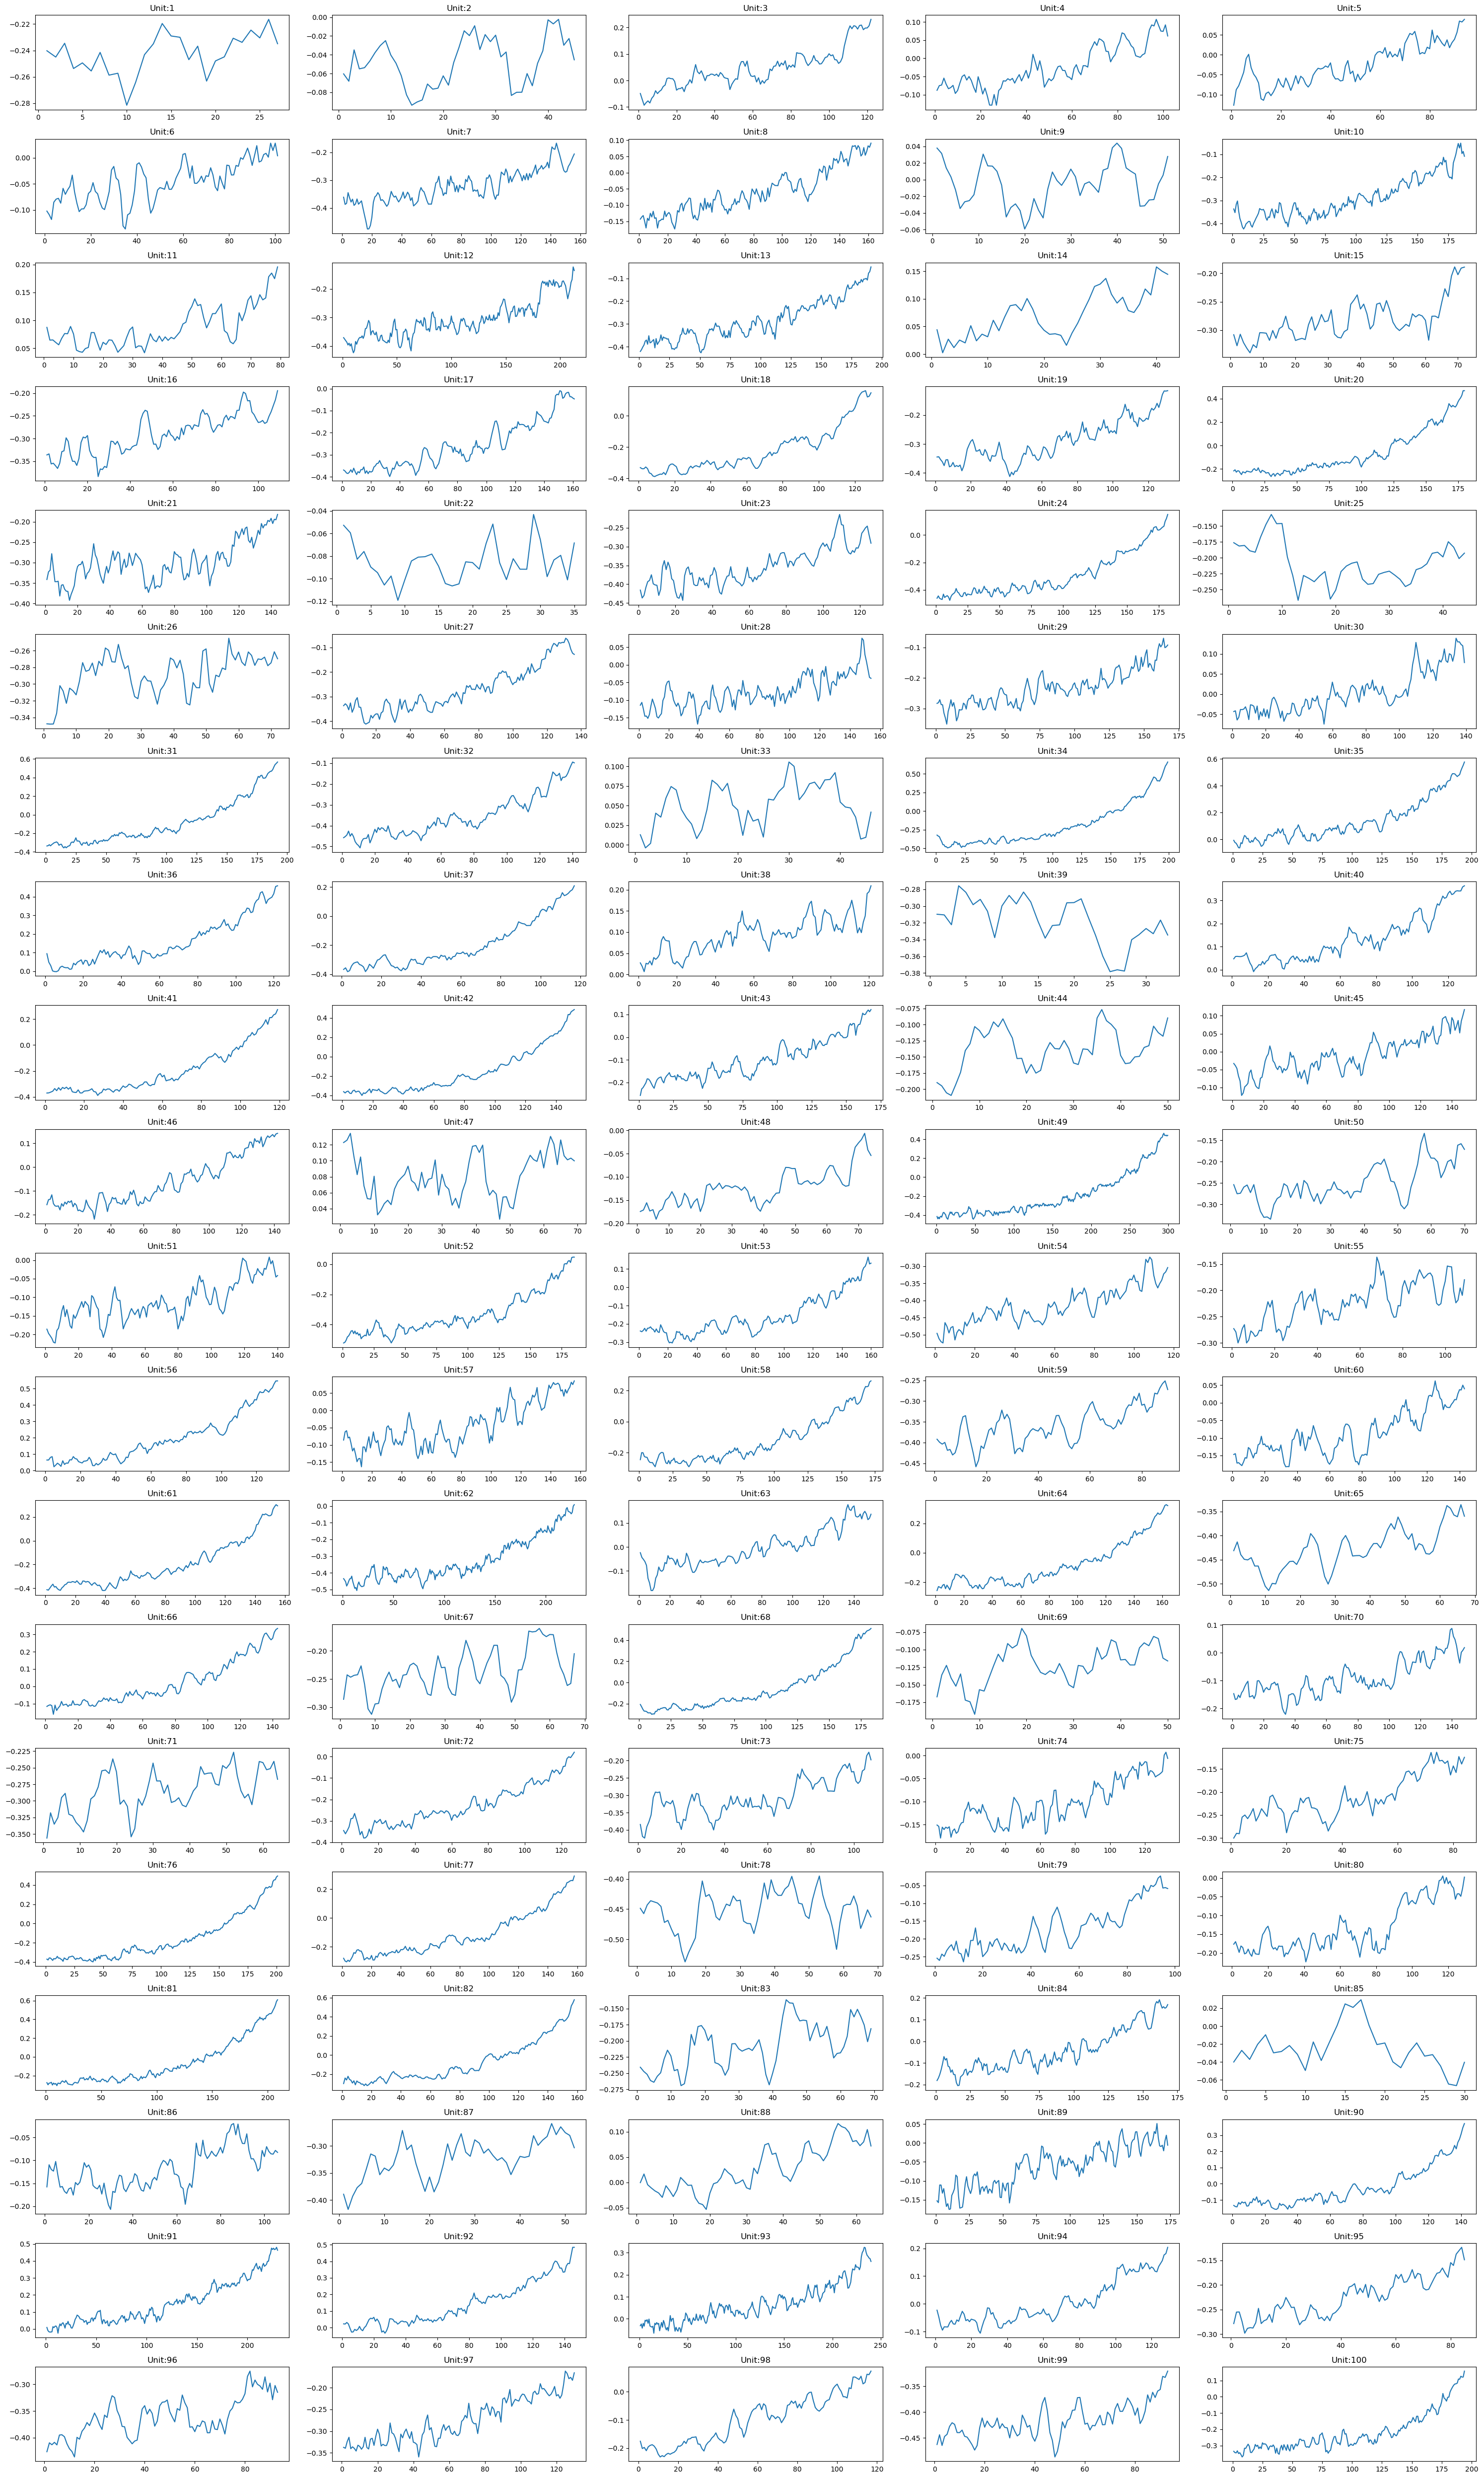

In [56]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):

    sns.lineplot(data = pca_test_df[pca_test_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

In [57]:
phi_vals = exp_params_df.phi
theta_vals = exp_params_df.theta
beta_vals = exp_params_df.beta

In [58]:
phi_vals.mean()

nan

In [59]:
param_1 = [phi_vals.mean(), theta_vals.mean(), beta_vals.mean()]
param_1

[nan, nan, nan]

In [61]:
lb = 25
ub = 75
phi_bounds = [np.percentile(phi_vals, lb), np.percentile(phi_vals, ub)]
theta_bounds = [np.percentile(theta_vals, lb), np.percentile(theta_vals, ub)]
beta_bounds = [np.percentile(beta_vals, lb), np.percentile(beta_vals, ub)]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
bounds = ([phi_bounds[0], theta_bounds[0], beta_bounds[0]],
          [phi_bounds[1], theta_bounds[1], beta_bounds[1]])
bounds

([-0.38839572068088796, 0.015356761551653976, 0.01632868353124362],
 [-0.07457237881353308, 0.029875215824846132, 0.023015291219069863])

In [ ]:
result_test_df = pd.DataFrame(columns = ['UnitNumber', 'phi', 'theta', 'beta', 'Pred_RUL', 'True_RUL'])

for i in pca_test_df.UnitNumber.unique():

    ht = pca_test_df.pc1[pca_test_df.UnitNumber == i]
    cycle = pca_test_df.cycle[pca_test_df.UnitNumber == i]

    OptimizeResult = optimize.least_squares(residuals, param_1, bounds=bounds,
                                            args = (cycle, ht, exp_degradation))
    phi, theta, beta = OptimizeResult.x
    total_cycles = np.log((threshold - phi) / theta) / beta
    RUL = total_cycles - cycle.max()

    result_test_df = result_test_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta,
                                         'Pred_RUL': RUL, 'True_RUL': y_true.RUL[y_true.UnitNumber == i].values[0]},
                                         ignore_index = True)

<ipython-input-52-8d8fe5670e1c>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test_df = result_test_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta,
<ipython-input-52-8d8fe5670e1c>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test_df = result_test_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta,
<ipython-input-52-8d8fe5670e1c>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test_df = result_test_df.append({'UnitNumber':i, 'phi': phi, 'theta': theta, 'beta': beta,
<ipython-input-52-8d8fe5670e1c>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_test_df = resul

In [ ]:
result_test_df.head()

NameError: name 'result_test_df' is not defined

In [ ]:
sns.regplot(x = result_test_df.Pred_RUL, y = result_test_df.True_RUL)
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

NameError: name 'result_test_df' is not defined

NameError: name 'result_test_df' is not defined

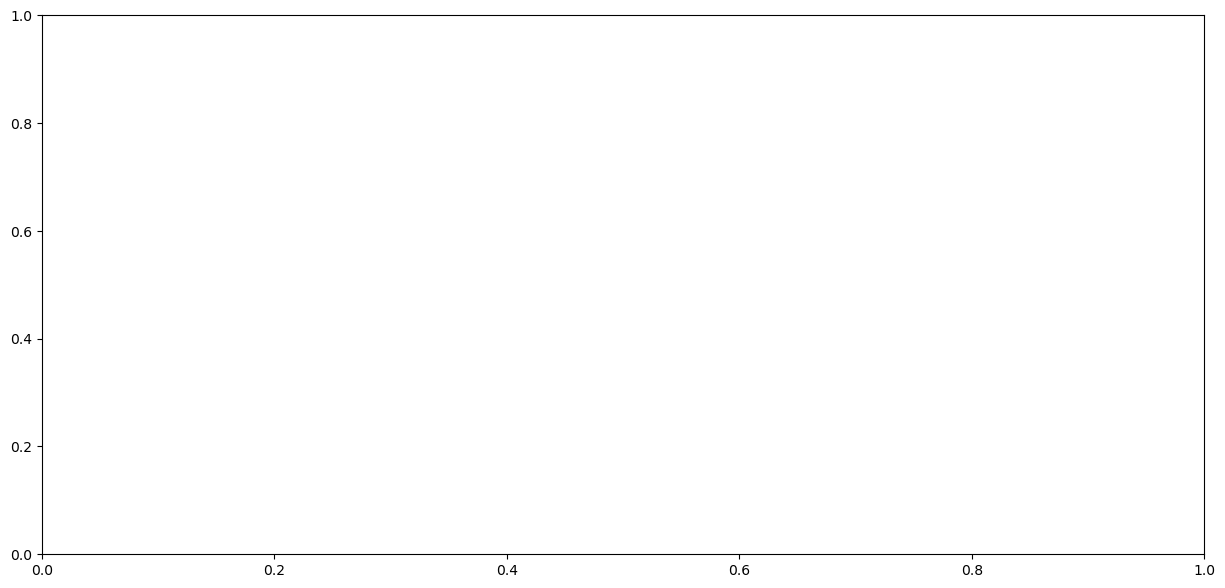

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = result_test_df.UnitNumber, y = result_test_df.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = result_test_df.UnitNumber, y = result_test_df.True_RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

NameError: name 'result_test_df' is not defined

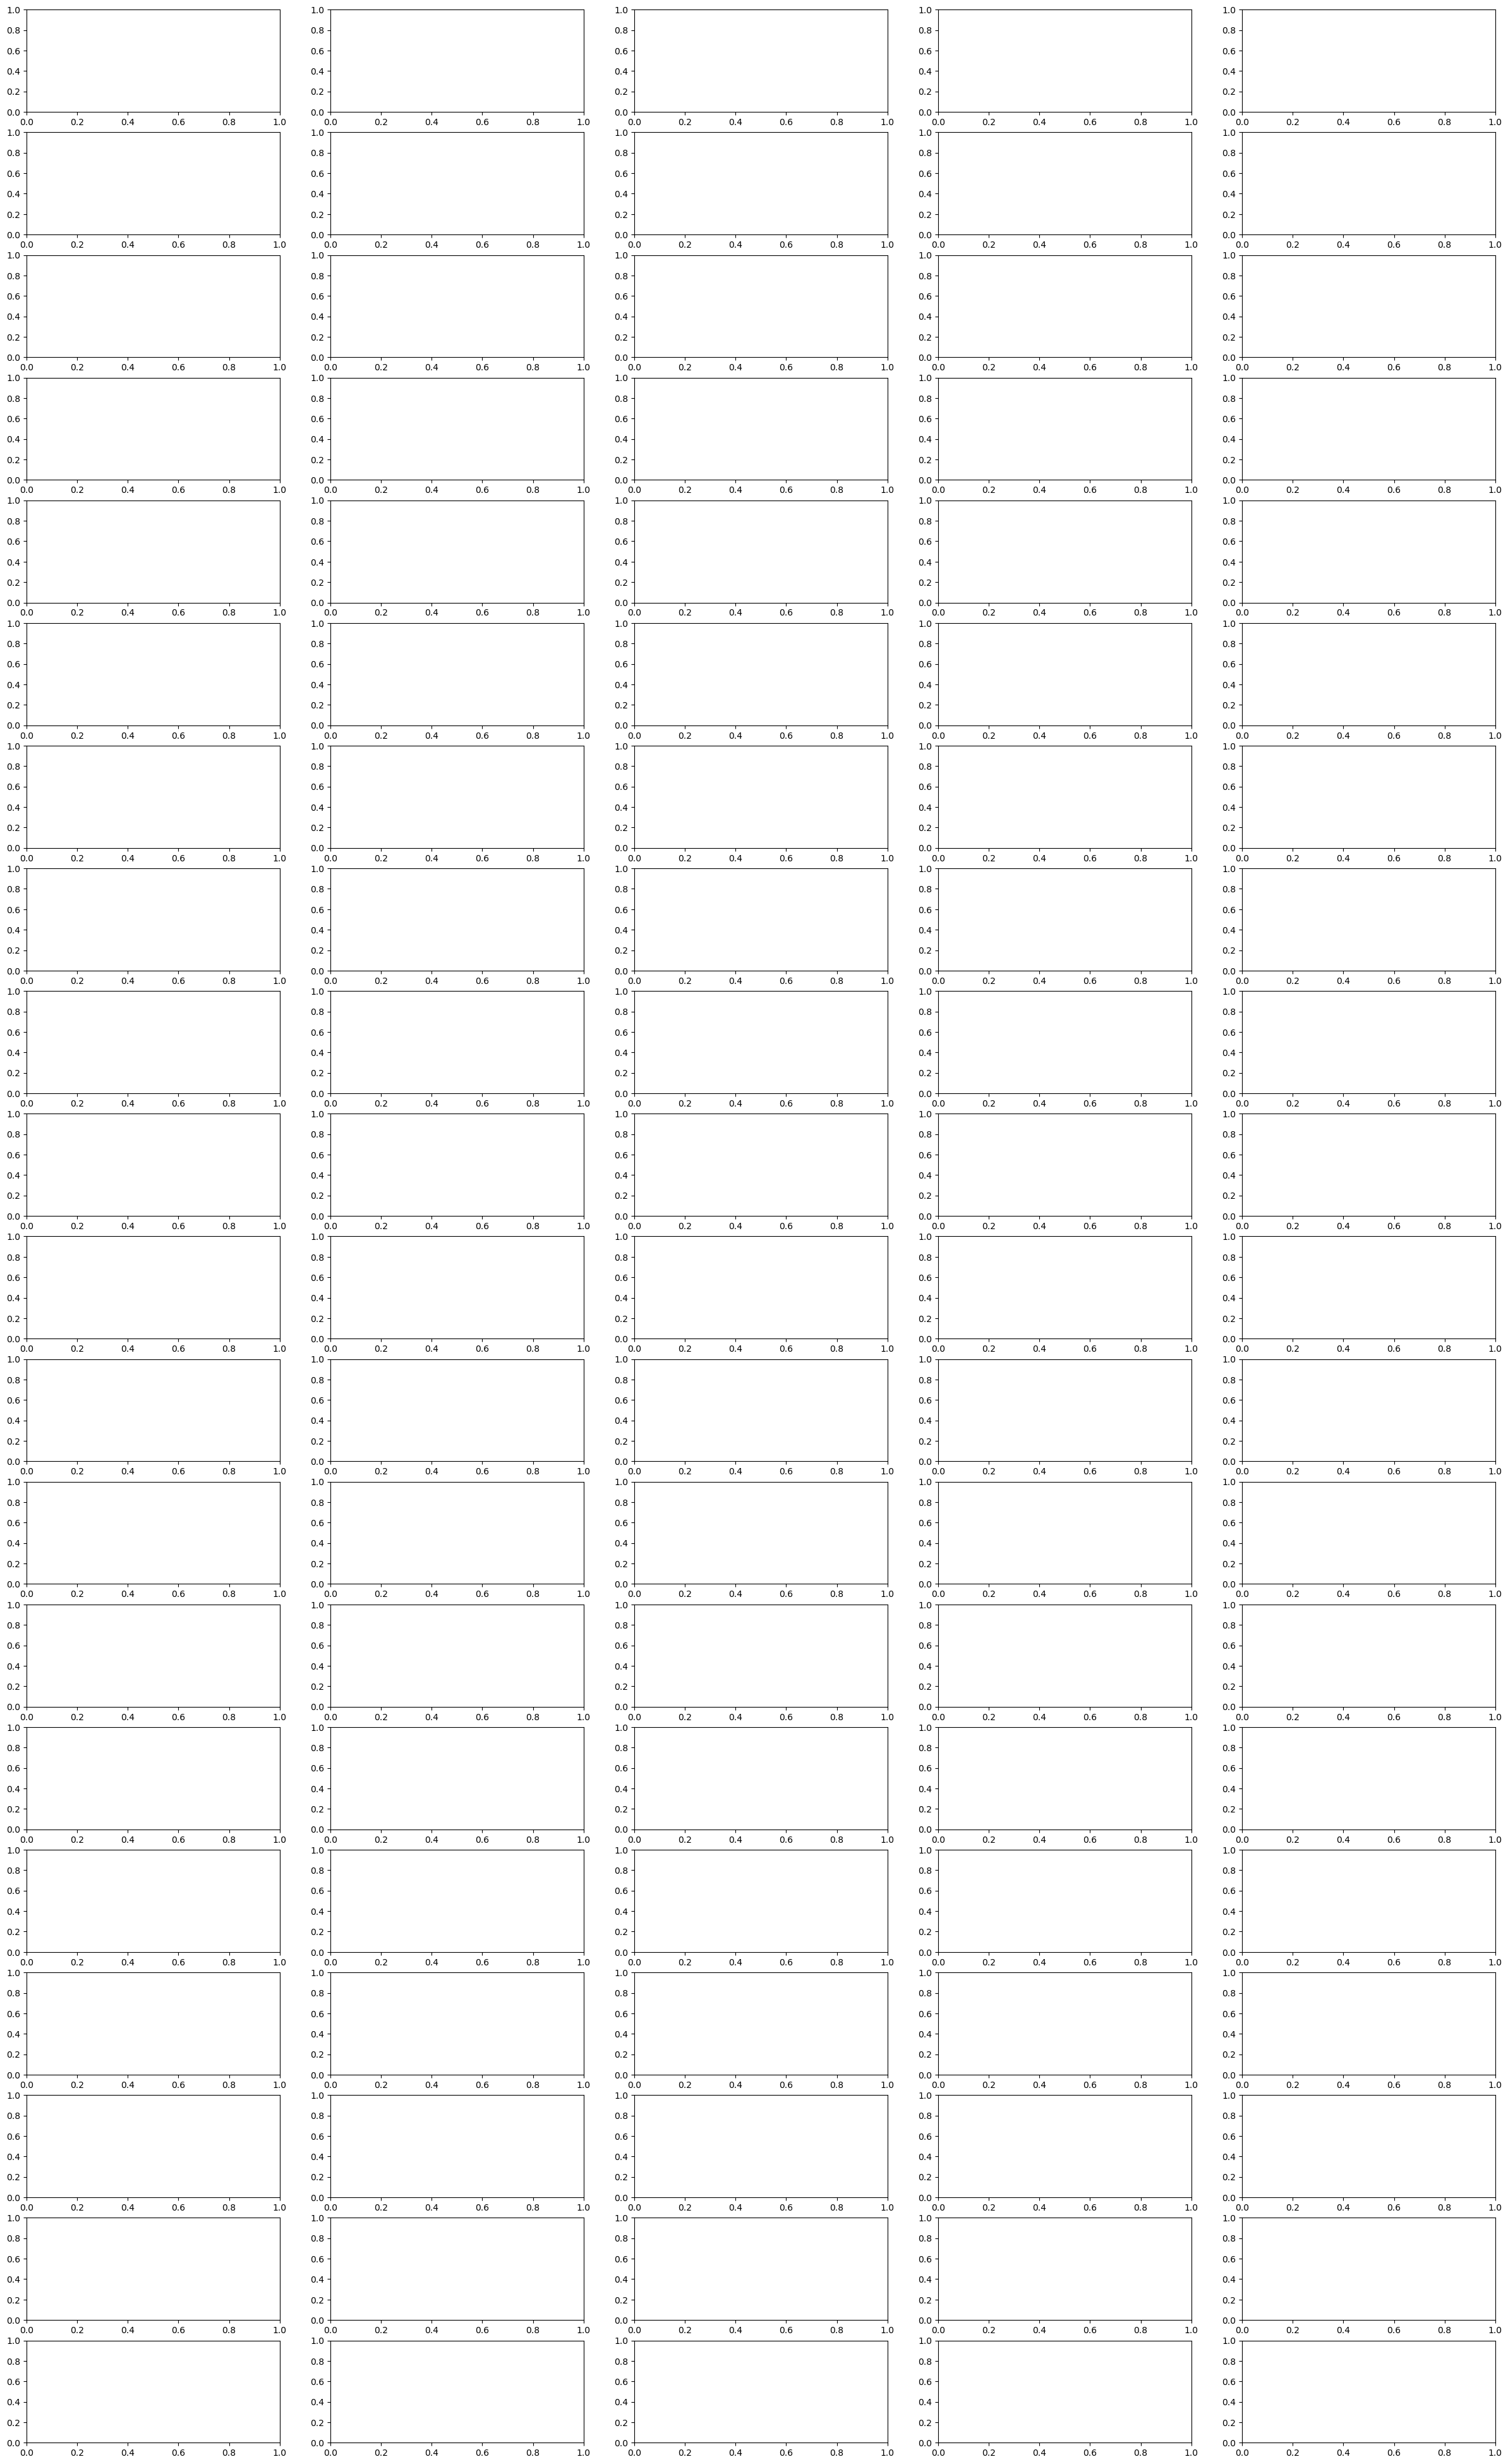

In [ ]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):

    phi = result_test_df.phi[result_test_df.UnitNumber == i+1].values[0]
    theta = result_test_df.theta[result_test_df.UnitNumber == i+1].values[0]
    beta = result_test_df.beta[result_test_df.UnitNumber == i+1].values[0]
    Pred_RUL = result_test_df.Pred_RUL[result_test_df.UnitNumber == i+1].values[0]

    cycles = pca_test_df.cycle[pca_test_df.UnitNumber == i+1]
    total_cycles = [j for j in range(1, int(cycles.max() + Pred_RUL + 1))]
    pred_ht = exp_degradation([phi, theta, beta], pd.Series(total_cycles))

    sns.lineplot(data = pca_test_df[pca_test_df.UnitNumber == i+1], x = "cycle", y = "pc1", ax = ax[i])
    sns.lineplot(y = pred_ht, x = total_cycles, ax = ax[i], color = "green")
    ax[i].axhline(threshold, color = 'r')
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

In [ ]:

mean_squared_error(result_test_df.True_RUL, result_test_df.Pred_RUL)

1013.6892134486549

In [ ]:
mean_absolute_error(result_test_df.True_RUL, result_test_df.Pred_RUL)

22.76249827029603

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(result_test_df.True_RUL, result_test_df.Pred_RUL)

33.655652673312716